In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
import sys
sys.path.insert(0, '..')

from Approximators import SKApproximator, AAAApproximator, PolelessBarycentric
import Approximators.Bernstein.CauchySimplex as Bernstein

In [3]:
import Approximators
Approximators.ignore_warnings()

# Noisy Approximation

In [4]:
colors = ['C3', 'C0', 'C2']
noise_str = r'$\mathcal{N}\,(0, 0.01^2)$'

In [5]:
N = 1000

In [6]:
target_functions = {r'|2(x - 0.5)|': lambda x: abs(2 * (x - 0.5)),
                    r'$\exp(-x)\, \sin(16x^2)$': lambda x: np.exp(-x) * np.sin(16 * x ** 2)}

In [7]:
n = 10

approximators = {f'Bernstein': Bernstein(n, n, max_iter=100, gamma=0.9),
                 f'AAA': AAAApproximator(n + 1, n + 1),
                 f'Polynomial': Bernstein(2 * n, 0)}

In [8]:
text_x_locations = [0.12, 0.17]
text_y_locations = [0.2, -0.5]

axin_xlims = [(0.45, 0.55), (0.75, 1.01)]
axin_ylims = [(-1e-2, 0.15), (0, 0.15)]

0: Pole Count 0
0: Pole Count 7
1: Pole Count 1
1: Pole Count 4


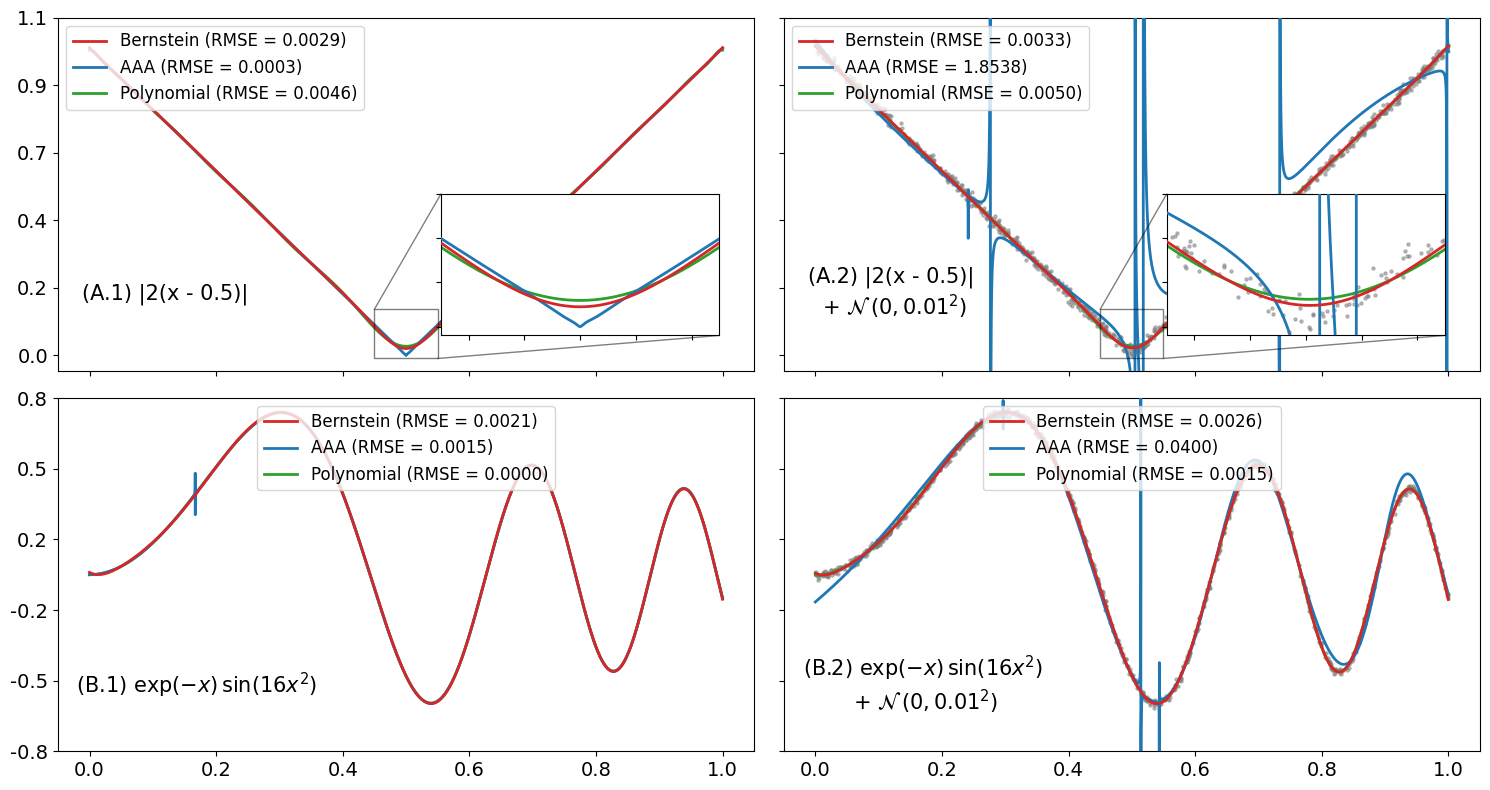

In [9]:
np.random.seed(0)

x = np.linspace(0, 1, 1001)
x_rand = np.random.rand(1000)
x_vals = np.linspace(0, 1, 10_001)

# Save to check with matlab implementation
np.savetxt(f'aaa_csv_files/x_rand.csv', x_rand, delimiter=',')

function_name = list(target_functions.keys())[0]
f = list(target_functions.values())[0]

fig, axs = plt.subplots(2, 2, figsize=(15, 8))

axins = np.array([[axs[0, 0].inset_axes([0.55, 0.1, 0.4, 0.4]), axs[0, 1].inset_axes([0.55, 0.1, 0.4, 0.4])]])

for i, (function_name, f) in enumerate(target_functions.items()):
    # Plot function with no noise
    y_temp = f(x)
    y_min, y_max = y_temp.min(), y_temp.max()
        
    for k in range(2):
        if i < 1:
            axins[i, k].set_ylim(*axin_ylims[i])
            axins[i, k].set_xlim(*axin_xlims[i])

            axins[i, k].set_xticklabels([])
            axins[i, k].set_yticklabels([])

            axs[i, k].indicate_inset_zoom(axins[i, k], edgecolor="black")
        
        y = y_temp if k == 0 else f(x_rand) + np.random.normal(0, 0.01, size=len(x_rand))
        
        if k == 1:
            np.savetxt(f'aaa_csv_files/y_small_noise_{i}.csv', y, delimiter=',')
            
            axs[i, k].scatter(x_rand, y, s=5, alpha=0.5, color='gray')
            if i < 1:
                axins[i, k].scatter(x_rand, y, s=5, alpha=0.5, color='gray')

        for j, (name, model) in enumerate(approximators.items()):
            if k == 0 and name == 'AAA':
                model = AAAApproximator(n + 1, n + 1, cleanup=False)
            
            x_temp = x if k == 0 else x_rand
            model.fit(x_temp, y)
            
            diff = model(x_vals) - f(x_vals)
            error = np.sqrt(np.mean(diff ** 2))
            label = f"{name} (RMSE = {error:.4f})"
            
            axs[i, k].plot(x_vals, model(x_vals), label=label, color=colors[j], linewidth=2, zorder=4-j)
            if i < 1:
                axins[i, k].plot(x_vals, model(x_vals), color=colors[j], linewidth=2, zorder=4-j)
            
            e = (y_max - y_min) * 0.05
            axs[i, k].set_ylim(y_min - e, y_max + e)
            
            if name == 'AAA':
                poles = model.poles()
                real_poles = np.real(poles[np.isreal(poles)])
                pole_count = np.sum((0 <= real_poles) * (real_poles <= 1))
                
                print(f"{i}: Pole Count {pole_count}")

    # Plot formatting stuff
    for k in range(2):
        label_loc = ['upper left', 'upper center', 'upper right'][i]
        axs[i, k].legend(fontsize=12, loc=label_loc)    
        
        text = f"({chr(65 + i)}.{k + 1}) {function_name}"
        if k == 1:
            text += f"\n + {noise_str}"
        axs[i, k].text(text_x_locations[i], text_y_locations[i], text, fontsize=15, 
                       horizontalalignment='center', verticalalignment='center')
        
    if i == 0:
        y_tick_locations = np.linspace(0, 1.1, 6)
    else:
        y_tick_locations = np.linspace(-0.8, 0.8, 6)
        
    axs[i, 0].set_yticks(y_tick_locations, [round(z, 1) for z in y_tick_locations])
    axs[i, 1].set_yticks(y_tick_locations, [None] * len(y_tick_locations))
    
    axs[i, 0].tick_params(labelsize=14)
    axs[i, 1].tick_params(labelsize=14)
        
    if i < 1:
        axs[i, 0].set_xticks(np.linspace(0, 1, 6), [None] * 6)
        axs[i, 1].set_xticks(np.linspace(0, 1, 6), [None] * 6)
        
plt.tight_layout()
plt.savefig('aaa_bernstein_plots.png', dpi=100)

# Convergence Plots

In [10]:
markers = ['o', 'v', 's', 'X', 'd', '*', 'p', '>']

In [11]:
clean_csv_files = ["aaa_tests/function_approx/csv_files/abs_mse_error.csv", 
                   "aaa_tests/function_approx/csv_files/exp_mse_error.csv"]

clean_poles_csv_files = ["aaa_tests/function_approx/csv_files/abs_pole_count.csv", 
                         "aaa_tests/function_approx/csv_files/exp_pole_count.csv"]

noisy_csv_files = ["aaa_tests/noisy_function/csv_files/abs_mse_error.csv", 
                   "aaa_tests/noisy_function/csv_files/exp_mse_error.csv"]

noisy_pole_csv_files = ["aaa_tests/noisy_function/csv_files/abs_pole_counts.csv", 
                        "aaa_tests/noisy_function/csv_files/exp_pole_counts.csv"]

text_labels = [r"$|2(x - 0.5)|$",
               r"$\exp(-x)\,\sin(16x^2)$"]

noise_str = r'$\mathcal{N}\,(0, 0.01^2)$'

In [12]:
approximators = ['Bernstein', 'AAA', 'Polynomial']
colors = ['C3', 'C0', 'C2']

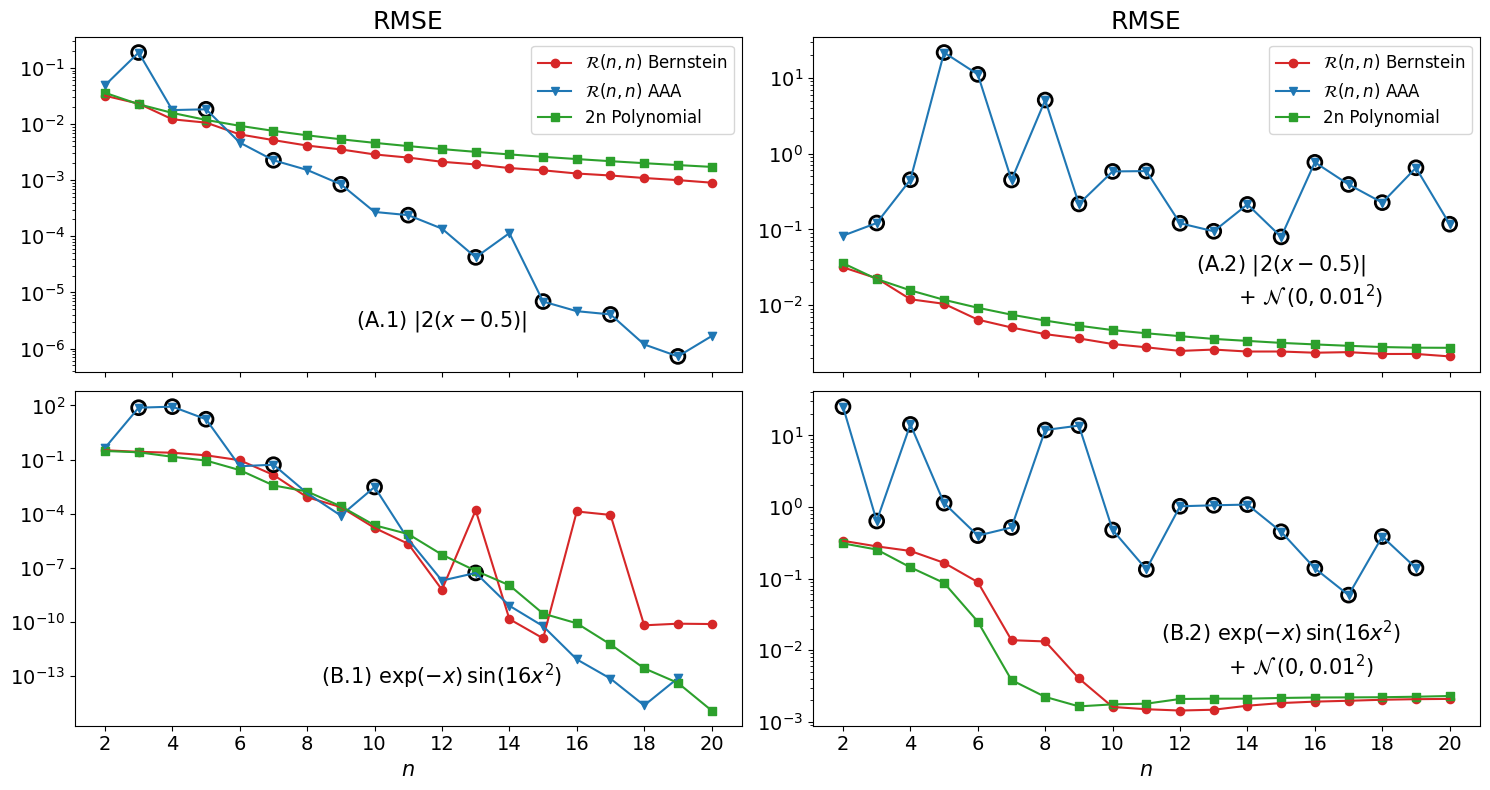

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

axs[0, 0].set_title('RMSE', fontsize=18)
axs[0, 1].set_title('RMSE', fontsize=18)

for i in range(2):
    name = text_labels[i]
    
    for j, (error_csv_file, pole_csv_file) in enumerate([(clean_csv_files[i], clean_poles_csv_files[i]),
                                                         (noisy_csv_files[i], noisy_pole_csv_files[i])]):
        
        result = np.sqrt(pd.read_csv(error_csv_file, index_col=0))
        pole_count = pd.read_csv(pole_csv_file, index_col=0)
        
        if i == 1:
            # For exp(-x) sin(16 x^2), AAA has converged at n=19, so deleting this point
            result.loc[20, 'AAA'] = None
            pole_count.loc[20, 'AAA'] = None
        
        for k, (col, color) in enumerate(zip(approximators, colors)):
            axs[i, j].plot(result[col], '-', color=color)
            
            axs[i, j].scatter(result.index, result.loc[:, col], marker=markers[k],
                              s=35, color=colors[k])
            
            poles_mask = pole_count[col] != 0
            axs[i, j].scatter(result.index[poles_mask], result.loc[poles_mask, col], 
                              facecolor='none', edgecolor='black', s=100, linewidths=2)
            
            if i == 0:
                label = "2n Polynomial" if col == 'Polynomial' else "$\mathcal{R}(n, n)$ " + col
                axs[i, j].plot([], [], color=colors[k], marker=markers[k], label=label, zorder=4)
    
    axs[i, 0].tick_params(labelsize=14)
    axs[i, 1].tick_params(labelsize=14)
    
    if i == 0:
        axs[i, 0].text(12, 3e-6, f"(A.1) {name}", fontsize=15, 
                       horizontalalignment='center', verticalalignment='center')
        axs[i, 1].text(15, 2e-2, f"(A.2) {name}\n         + " + noise_str, fontsize=15, 
                       horizontalalignment='center', verticalalignment='center')
    else:
        axs[i, 0].text(12, 1e-13, f"(B.1) {name}", fontsize=15, 
                       horizontalalignment='center', verticalalignment='center')
        axs[i, 1].text(15, 1e-2, f"(B.2) {name}\n      + " + noise_str, fontsize=15, 
                       horizontalalignment='center', verticalalignment='center')
    
    if i == 0:
        axs[i, 0].legend(fontsize=12)
        axs[i, 1].legend(fontsize=12)
    
    for j in range(2):
        axs[i, j].set_yscale('log')
        
        x_ticks_locations = np.arange(2, 21, 2)
        if i < 1:
            axs[i, j].set_xticks(x_ticks_locations, [None] * len(x_ticks_locations))
        else:
            axs[i, j].set_xticks(x_ticks_locations, x_ticks_locations)
            axs[i, j].set_xlabel("$n$", fontsize=15)
            
plt.tight_layout()
plt.savefig('aaa_bernstein_convergence_plots.png', dpi=100)